In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gluonnlp as nlp
import numpy as np
from tqdm import tqdm, tqdm_notebook
import re
import pandas as pd

from kobert.utils import get_tokenizer
from kobert.pytorch_kobert import get_pytorch_kobert_model

from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup

2022-11-17 12:57:15.103348: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [2]:
##GPU 사용 시
device = torch.device("cuda:0")

In [3]:
## Setting parameters
max_len = 64
batch_size = 64
warmup_ratio = 0.1
num_epochs = 3
max_grad_norm = 1
log_interval = 200
learning_rate =  5e-5

In [4]:
bertmodel, vocab = get_pytorch_kobert_model()

using cached model. /home/mglee/VSCODE/git_folder/naver_comments/code/.cache/kobert_v1.zip
using cached model. /home/mglee/VSCODE/git_folder/naver_comments/code/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


In [5]:
tokenizer = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)

using cached model. /home/mglee/VSCODE/git_folder/naver_comments/code/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


In [6]:
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes=2,
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate
                 
        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)
    
    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)
        
        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device))
        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out)

In [7]:
pred_model = torch.load('/home/mglee/VSCODE/git_folder/NLP-Practice/result/KoBERT_0705_e15_py.pt')  # 전체 모델을 통째로 불러옴, 클래스 선언 필수
# pred_model.load_state_dict(torch.load(PATH + 'Kobert_0627_py_state_dict.pt'))  # state_dict를 불러 온 후, 모델에 저장
 
# checkpoint = torch.load(PATH + 'all.tar')   # dict 불러오기
# pred_model.load_state_dict(checkpoint['model'])
#optimizer.load_state_dict(checkpoint['optimizer'])


pred_model = BERTClassifier(bertmodel, dr_rate = 0.5).to(device)

pred_model.load_state_dict(torch.load('/home/mglee/VSCODE/git_folder/NLP-Practice/result/Kobert_0928_e3_py_state_dict.pt'))  # state_dict를 불러 온 후, 모델에 저장


FileNotFoundError: [Errno 2] No such file or directory: '/home/mglee/VSCODE/git_folder/NLP-Practice/result/KoBERT_0705_e15_py.pt'

In [9]:
df10 = pd.read_pickle('../result/naver_POSCO_comments_1005.pkl')
df09 = pd.read_pickle('../result/naver_POSCO_comments.pkl')
df = pd.concat([df09, df10])
df.reset_index(drop = True, inplace = True)

In [11]:
df.head(1)

,comment,reply,author,like,dislike,c_time,cid,pid,sid,time,title,media
0,"""최정우 회장은 저거 말고도 물적분할건과 주주들에게 약속한 배당도 안주고 또 회사 ...",0,"""4tsNy""",38,3,"""2022-09-30T11:21:14+0900""",770753006533607540,770753006533607540,102,2022.09.30. 오전 10:09,"[단독]최정우 향한 '포스코 자사주 매입' 의혹, 중앙지검 반부패3부에서 재수사 착수",시사저널


In [12]:
body = df.loc[:,['comment']]

In [13]:
body['label'] = 0

In [14]:
body

,comment,label
0,"""최정우 회장은 저거 말고도 물적분할건과 주주들에게 약속한 배당도 안주고 또 회사 ...",0
1,"""강백신 부장검사를 배치하다니.. 엄청나다 엄청나..\n 친윤 변호사들 몇 명이라도...",0
2,"""포스코창립이래 최악 무능 최정우 부산대 문과출신의 몰락. 포스코 젊은인재들 떠나...",0
3,"""최정우로인해 포스코주주들은 피눈물흘리는중""",0
4,"""제발 처벌좀...""",0
...,...,...
28641,"""개돼지 소리들을것도 아니고 뭔 국감을없애요. 모두 불러서 잘잘못을 가려야 합니다.""",0
28642,"""좋은 정책 지지 합니다""",0
28643,"""지금이라도 포기해라 이거 인수하다 둘다 망한다...""",0
28644,"""한심하다...그러면 뭐하나...""",0


In [15]:
class BERTDataset_test(Dataset):
    def __init__(self, dataset,bert_tokenizer, max_len,
                 pad, pair):
        transform = nlp.data.BERTSentenceTransform(
            bert_tokenizer, max_seq_length=max_len, pad=pad, pair=pair)

        self.sentences = [transform([" ".join(str(dataset.iloc[i]['comment']))]) for i in range(len(dataset))]
        self.labels = [np.int32(dataset.iloc[i]['label']) for i in range(len(dataset))]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))

In [16]:
comment_bert = BERTDataset_test(body, tok, max_len, True, False)

In [17]:
pred_dataloader = torch.utils.data.DataLoader(comment_bert, batch_size = batch_size, num_workers = 8)

In [18]:
for data in pred_dataloader:
  print("Data: ", data)
  break

Data:  [tensor([[   2,  518, 4519,  ..., 5849,  517,    3],
        [   2,  518,  807,  ..., 4743,  517,    3],
        [   2,  518, 4856,  ..., 3220, 1875,    3],
        ...,
        [   2,  518,  517,  ..., 5330,  517,    3],
        [   2,  518, 5211,  ...,    1,    1,    1],
        [   2,  518, 1457,  ...,    1,    1,    1]], dtype=torch.int32), tensor([64, 64, 64, 28, 15, 12, 64, 31,  8, 10, 32, 16, 16, 42, 10, 15,  9, 64,
        64, 56, 27, 64, 40, 39, 30, 64, 64, 29, 64, 26, 64, 21, 23, 54, 36, 30,
        51, 50, 64, 56, 27, 64, 40, 39, 30, 64, 64, 29, 64, 26, 64, 21, 23, 54,
        36, 30, 51, 50, 64, 56, 27, 64, 40, 39], dtype=torch.int32), tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.int32), tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0,

In [28]:
out_lst = []

for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm(pred_dataloader)):
    token_ids = token_ids.long().to(device)
    segment_ids = segment_ids.long().to(device)
    valid_length= valid_length
    #label = label.long().to(device)
    out = pred_model(token_ids, valid_length, segment_ids)
    out_lst.append(out.data.cpu())
    max_vals, max_indices = torch.max(out, 1)

100%|██████████| 448/448 [00:17<00:00, 25.45it/s]


In [29]:
pred = []
for batch in out_lst:
    for item in batch:
        pred.append(np.argmax(item.numpy()))

In [30]:
df['sentiment'] = pred

In [33]:
df.groupby('sentiment').size()

sentiment
0    24702
1     3944
dtype: int64

In [42]:
df.to_csv("../result/POSCO_comment_sentiment_0910.csv")

In [43]:
df.groupby('media').size().sort_values(ascending = False)[:10]

media
한국경제      3764
디지털타임스    1786
서울신문      1691
중앙일보      1684
이데일리      1447
매일경제      1346
뉴시스       1272
연합뉴스      1109
서울경제       834
동아일보       738
dtype: int64

In [46]:
df['c_day'] = df.c_time.apply(lambda x : x[6:11])

In [47]:
import matplotlib.pyplot as plt

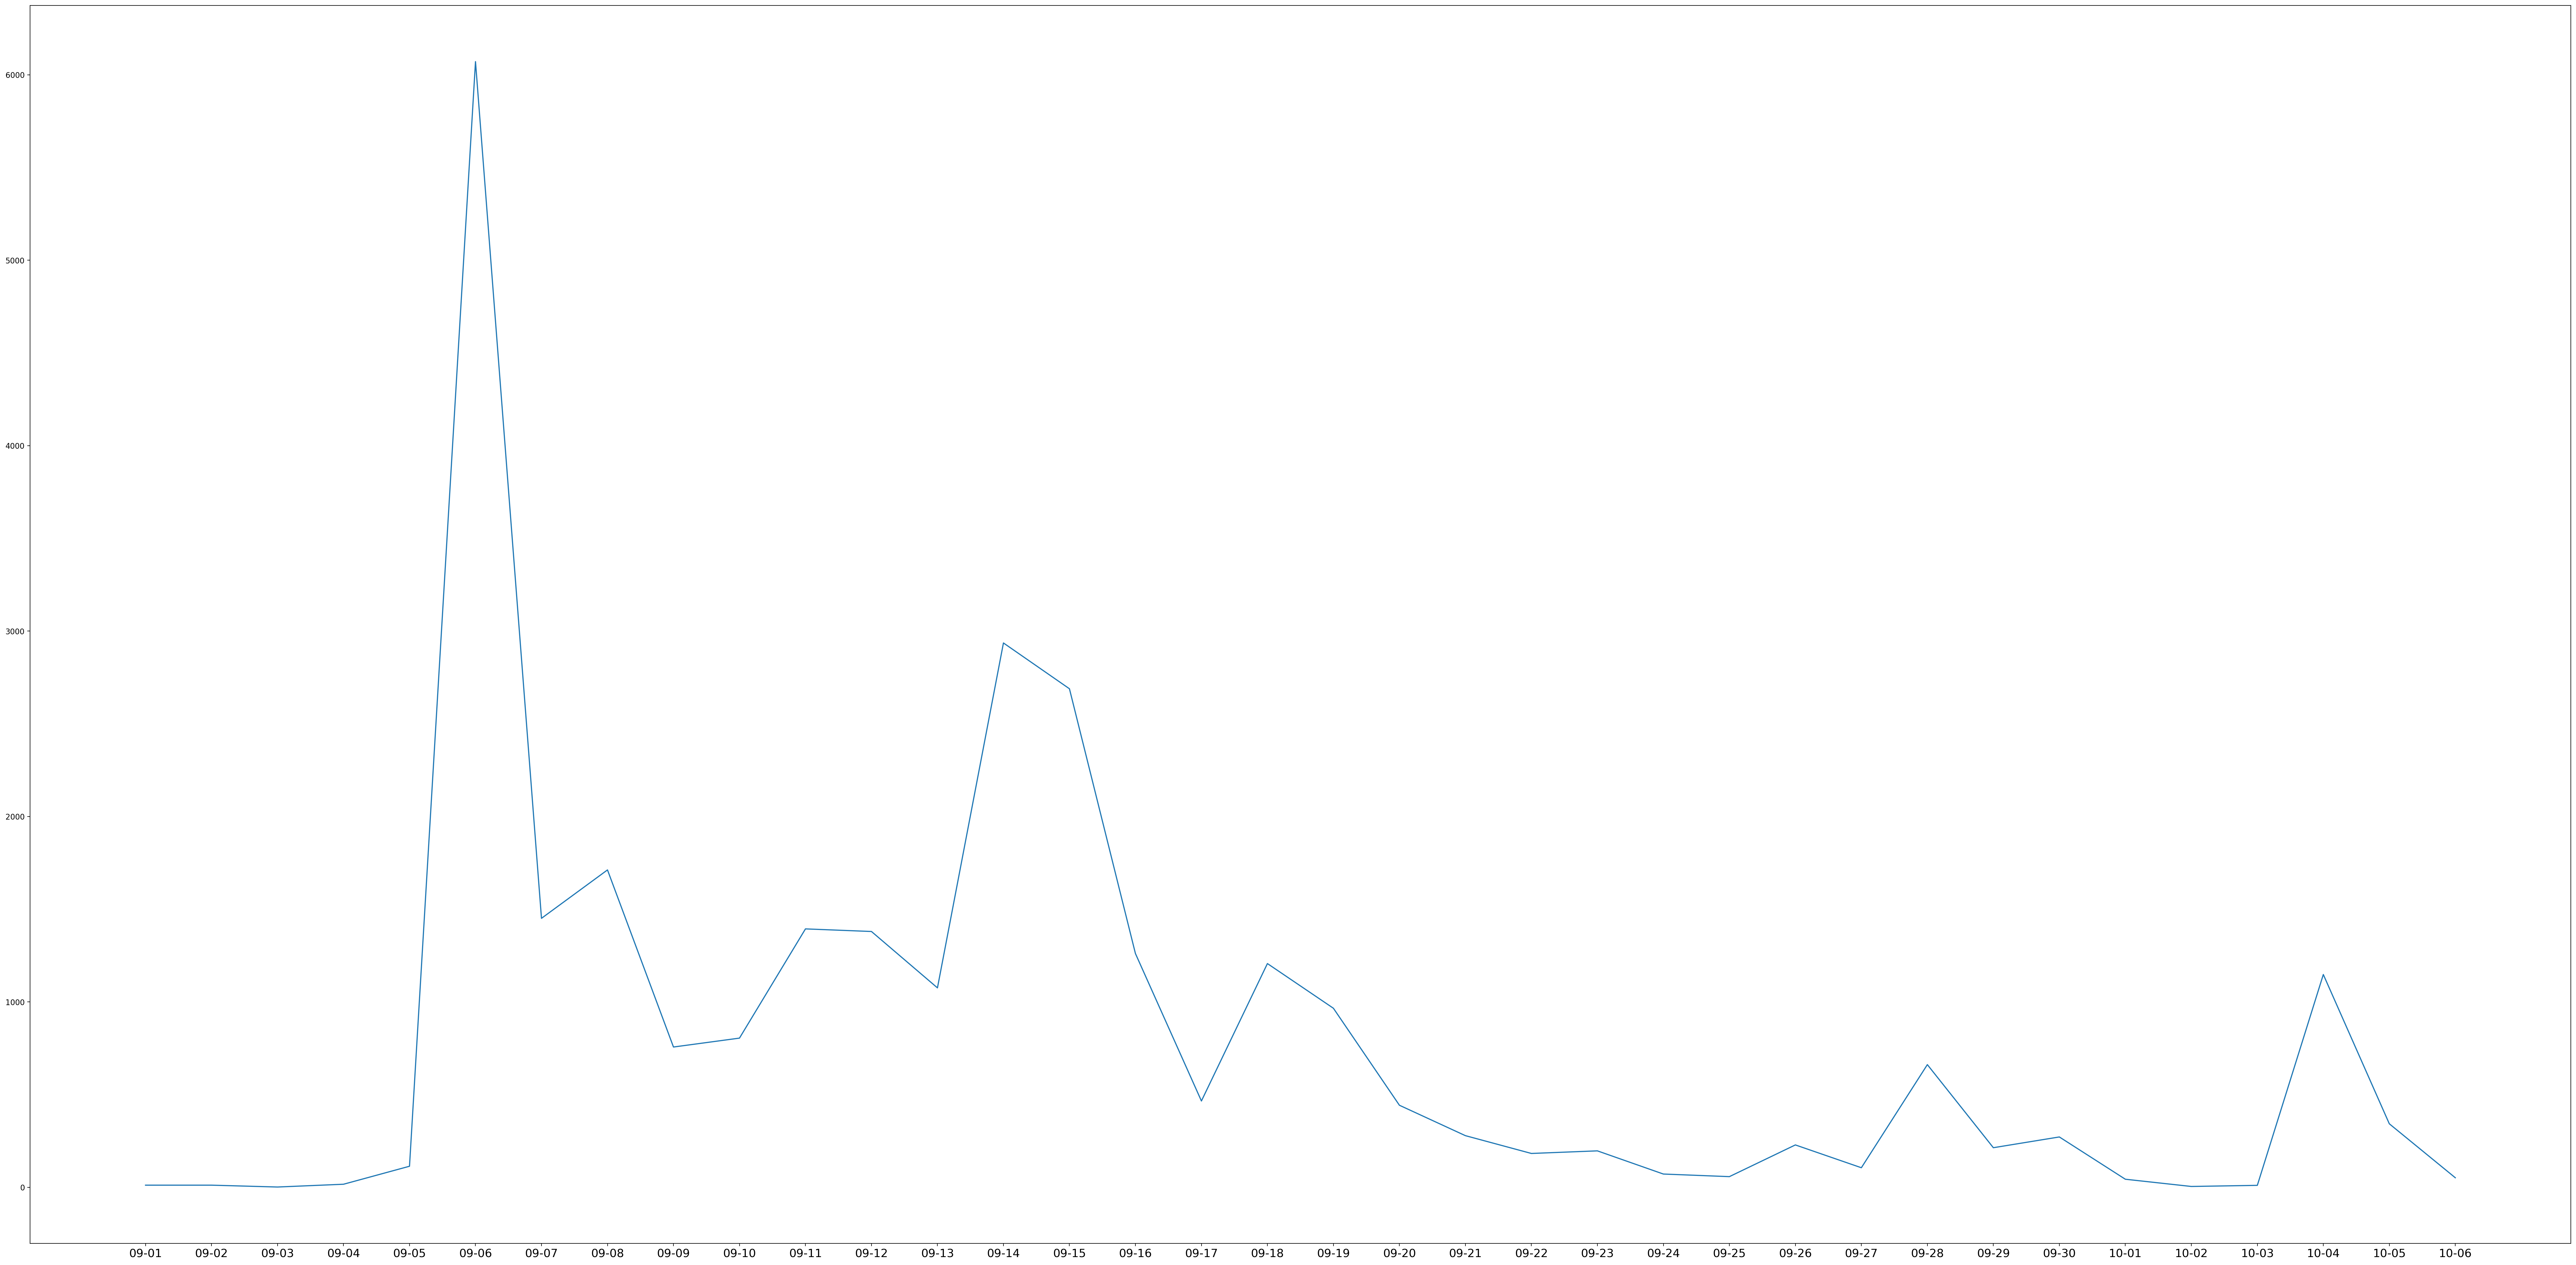

In [54]:
parameters = {'xtick.labelsize': 15,
          'axes.titlesize': 30,
          'figure.figsize' : (60, 30),
          'figure.dpi' : 200
          }
plt.rcParams.update(parameters)

plt.plot(df.groupby('c_day').size().sort_index())

In [50]:
df

,comment,reply,author,like,dislike,c_time,cid,pid,sid,time,title,media,sentiment,c_day
0,"""최정우 회장은 저거 말고도 물적분할건과 주주들에게 약속한 배당도 안주고 또 회사 ...",0,"""4tsNy""",38,3,"""2022-09-30T11:21:14+0900""",770753006533607540,770753006533607540,102,2022.09.30. 오전 10:09,"[단독]최정우 향한 '포스코 자사주 매입' 의혹, 중앙지검 반부패3부에서 재수사 착수",시사저널,0,09-30
1,"""강백신 부장검사를 배치하다니.. 엄청나다 엄청나..\n 친윤 변호사들 몇 명이라도...",0,"""3rVbk""",27,2,"""2022-09-30T11:54:47+0900""",770755168059785600,770755168059785600,102,2022.09.30. 오전 10:09,"[단독]최정우 향한 '포스코 자사주 매입' 의혹, 중앙지검 반부패3부에서 재수사 착수",시사저널,0,09-30
2,"""포스코창립이래 최악 무능 최정우 부산대 문과출신의 몰락. 포스코 젊은인재들 떠나...",0,"""6wZ6I""",12,1,"""2022-09-30T23:08:05+0900""",770798544830332975,770798544830332975,102,2022.09.30. 오전 10:09,"[단독]최정우 향한 '포스코 자사주 매입' 의혹, 중앙지검 반부패3부에서 재수사 착수",시사저널,0,09-30
3,"""최정우로인해 포스코주주들은 피눈물흘리는중""",0,"""1Ucu4""",12,3,"""2022-09-30T12:00:02+0900""",770755506774999057,770755506774999057,102,2022.09.30. 오전 10:09,"[단독]최정우 향한 '포스코 자사주 매입' 의혹, 중앙지검 반부패3부에서 재수사 착수",시사저널,0,09-30
4,"""제발 처벌좀...""",0,"""1pfiN""",10,2,"""2022-09-30T11:38:00+0900""",770754086499778571,770754086499778571,102,2022.09.30. 오전 10:09,"[단독]최정우 향한 '포스코 자사주 매입' 의혹, 중앙지검 반부패3부에서 재수사 착수",시사저널,0,09-30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28641,"""개돼지 소리들을것도 아니고 뭔 국감을없애요. 모두 불러서 잘잘못을 가려야 합니다.""",0,"""14EBH""",0,0,"""2022-10-04T19:10:36+0900""",771154330005799166,771154330005799166,101,2022.10.04. 오후 5:22,"[기자수첩]기업인 호통 국감, 이젠 사라져야",이데일리,0,10-04
28642,"""좋은 정책 지지 합니다""",0,"""eDYy""",0,0,"""2022-10-06T06:27:14+0900""",771290694026264626,771290694026264626,102,2022.10.05. 오전 1:02,"호미반도, 국가해양정원 조성 ‘속도’",세계일보,1,10-06
28643,"""지금이라도 포기해라 이거 인수하다 둘다 망한다...""",0,"""2sDOh""",7,0,"""2022-10-04T15:22:22+0900""",771139626906681512,771139626906681512,101,2022.10.04. 오전 7:01,[공시줍줍]아시아나 지분인수 기일 또 미룬 대한항공,비즈니스워치,0,10-04
28644,"""한심하다...그러면 뭐하나...""",0,"""S8Z7""",0,0,"""2022-10-06T06:44:27+0900""",771291802396262491,771291802396262491,101,2022.10.04. 오전 7:01,[공시줍줍]아시아나 지분인수 기일 또 미룬 대한항공,비즈니스워치,0,10-06


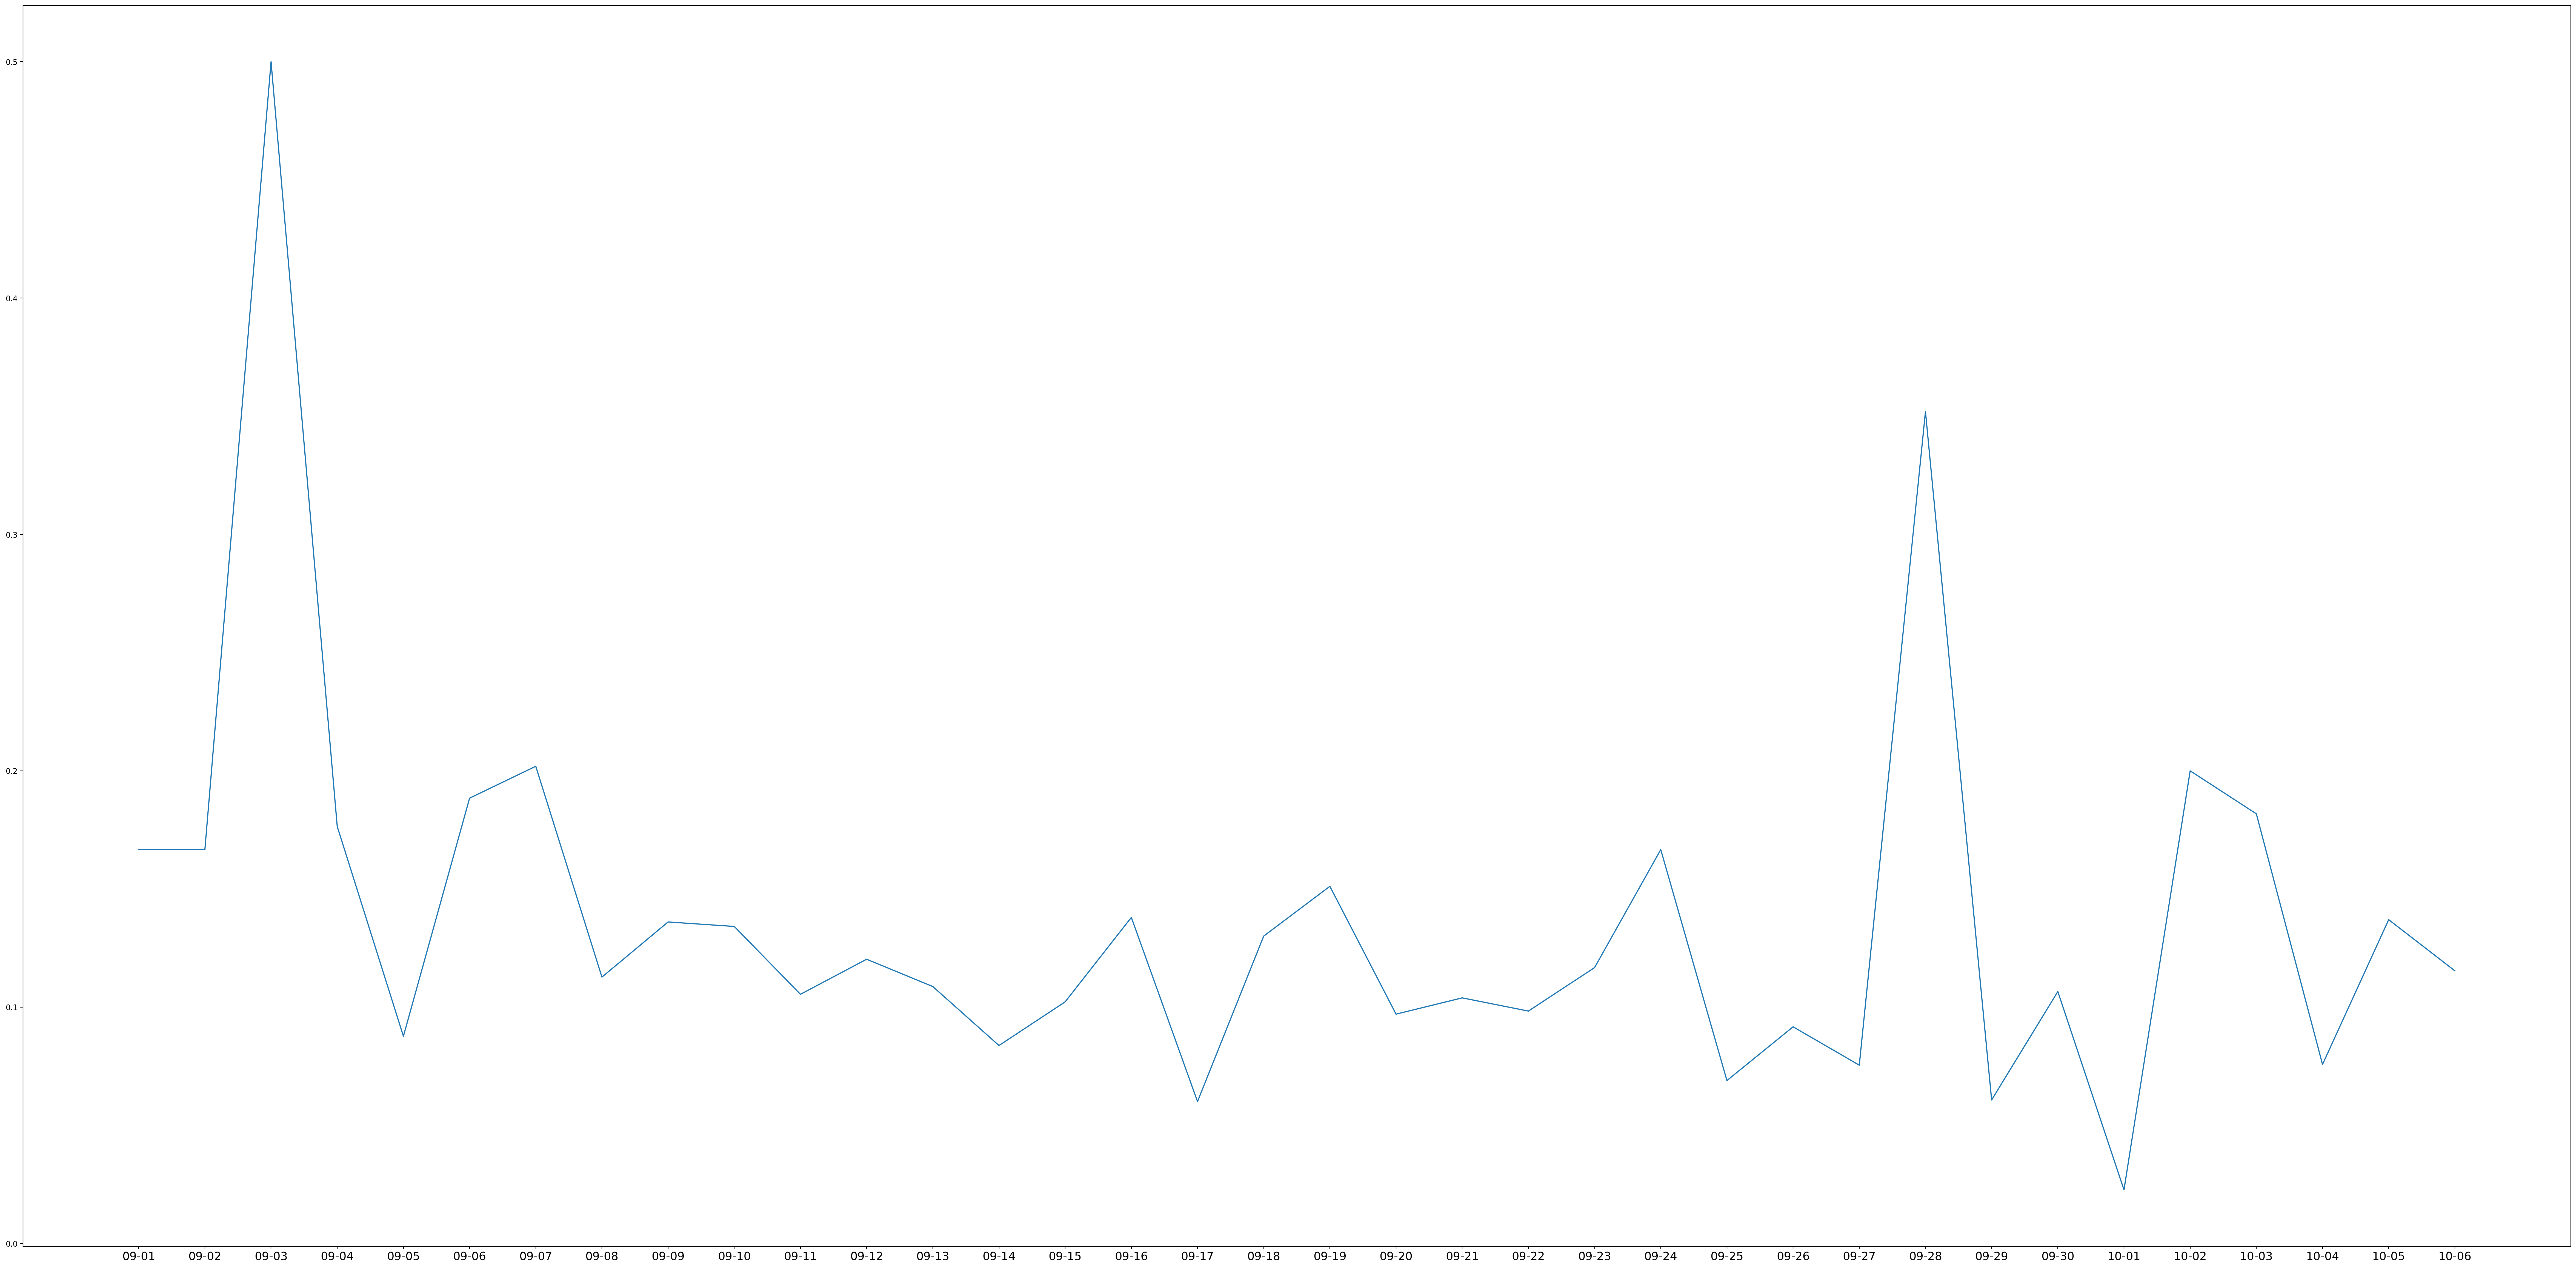

In [55]:
plt.plot(df.groupby('c_day').mean('sentiment'))

In [67]:
df.groupby('media').mean('sentiment').sort_values('sentiment', ascending = False)[32:]

,sentiment
media,
YTN,0.121951
TV조선,0.121127
경향신문,0.118056
한겨레,0.116800
조선일보,0.115839
시사저널,0.114754
디지털타임스,0.114222
SBS Biz,0.108187
데일리안,0.107438
